In [1]:
# --------------------------------------------------
# TREC IS 2020 Evaluation Script
# Configured for 2020-A Events
# Task 1
# Used to evaluate TREC-IS runs
# --------------------------------------------------
version = 2.4 # Notebook Version Number

import os
cwd = os.getcwd()
runFile = "marks2.run"

# Configuration (Change this to match your setting)
# System output file to evaluate:
# runFile = "cbnuC1"
# runName = "cbnuC1"
runName = "marksrun2"

# Do we try and normalize the run priority scores?
enablePriorityNorm = False

# The location of the ground truth data against which to compare the run
classificationLabelFiles = [
    "../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr1.json",
    "../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr2.json",
    "../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr3.json",
    "../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr4.json",
    "../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr5.json"
]
classificationLabelFiles = [x for x in classificationLabelFiles]

# The location of the ontology file
ontologyFile = "../../../0-data/raw/data/2020/2020-A/types/TRECIS-2020-ITypes-Task1.json"


# --------------------------------------------------
# Static data for the 2019 edition
# --------------------------------------------------
# Identifiers for the test events
eventIdentifiers = [
    "athensEarthquake2020",
    "baltimoreFlashFlood2020",
    "brooklynBlockPartyShooting2020",
    "daytonOhioShooting2020",
    "elPasoWalmartShooting2020",
    "gilroygarlicShooting2020",
    "hurricaneBarry2020",
    "indonesiaEarthquake2020",
    "keralaFloods2020",
    "myanmarFloods2020",
    "papuaNewguineaEarthquake2020",
    "siberianWildfires2020",
    "typhoonKrosa2020",
    "typhoonLekima2020",
    "whaleyBridgeCollapse2020"
]

eventidTopicidMap =	{
  "athensEarthquake2020": "TRECIS-CTIT-H-Test-035",
  "baltimoreFlashFlood2020": "TRECIS-CTIT-H-Test-036",
  "brooklynBlockPartyShooting2020": "TRECIS-CTIT-H-Test-037",
  "daytonOhioShooting2020": "TRECIS-CTIT-H-Test-038",
  "elPasoWalmartShooting2020": "TRECIS-CTIT-H-Test-039",
  "gilroygarlicShooting2020": "TRECIS-CTIT-H-Test-040",
  "hurricaneBarry2020": "TRECIS-CTIT-H-Test-041",
  "indonesiaEarthquake2020": "TRECIS-CTIT-H-Test-042",
  "keralaFloods2020": "TRECIS-CTIT-H-Test-043",
  "myanmarFloods2020": "TRECIS-CTIT-H-Test-044",
  "papuaNewguineaEarthquake2020": "TRECIS-CTIT-H-Test-045",
  "siberianWildfires2020": "TRECIS-CTIT-H-Test-046",
  "typhoonKrosa2020": "TRECIS-CTIT-H-Test-047",
  "typhoonLekima2020": "TRECIS-CTIT-H-Test-048",
  "whaleyBridgeCollapse2020": "TRECIS-CTIT-H-Test-049"
}

# What we consider to be highly important categories of information
highImportCategories = [
    "Request-GoodsServices",
    "Request-SearchAndRescue",
    "CallToAction-MovePeople",
    "Report-EmergingThreats",
    "Report-NewSubEvent",
    "Report-ServiceAvailable"
]

highImportCategoriesShort = [
    "GoodsServices",
    "SearchAndRescue",
    "MovePeople",
    "EmergingThreats",
    "NewSubEvent",
    "ServiceAvailable"
]

# Parameters
var_lambda = 0.75 # weight to place on actionable information categories in comparison to non actionable categoriee
var_alpha = 0.3 # Flat gain for providing a correct alert, regardless of the categories selected

resultsFile = open(runName+".results.task1.overall.txt","w+")
resultsFile.write("TREC-IS 2020-A Task 1 Notebook Evaluator v"+str(version)+"\n")
resultsFile.write("Run: "+runName+" ("+runFile+")"+"\n")
resultsFile.write(""+"\n")

perTopicFile = open(runName+".results.task1.pertopic.txt","w+")
perTopicFile.write("TREC-IS 2020-A Task 1 Notebook Evaluator v"+str(version)+"\n")
perTopicFile.write("Run: "+runName+" ("+runFile+")"+"\n")
perTopicFile.write(""+"\n")

perEventFile = open(runName+".results.task1.perevent.txt","w+")
perEventFile.write("TREC-IS 2020-A Task 1 Notebook Evaluator v"+str(version)+"\n")
perEventFile.write("Run: "+runName+" ("+runFile+")"+"\n")
perEventFile.write(""+"\n")


# --------------------------------------------------
# Processing Starts Here
# --------------------------------------------------
import json
from pprint import pprint
import gzip
import math
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Stage 1: Load the ground truth dataset 
# --------------------------------------------------

groundtruthJSON = []
for groundtruthFile in classificationLabelFiles:
    print("Reading "+groundtruthFile)
    with open(groundtruthFile, encoding='iso-8859-1') as groundtruthJSONFile:    
        groundtruthJSON.append(json.load(groundtruthJSONFile))
#pprint(groundtruthJSON["events"])

# --------------------------------------------------
# Stage 2: Load run file 
# --------------------------------------------------
with open(runFile, encoding='utf-8') as openRunFile:
    runContents = openRunFile.readlines() # lines not yet decoded
#pprint(runContents[0])

# --------------------------------------------------
# Stage 3: Load the categories 
# --------------------------------------------------
with open(ontologyFile, encoding='utf-8') as ontologyJSONFile:    
    ontologyJSON = json.load(ontologyJSONFile)

informationTypes2Index = {} # category -> numerical index
informationTypesShort2Index = {} # category short form (e.g. Report-EmergingThreats vs. EmergingThreats) -> numerical index
informationTypeIndex = 0
for informationTypeJSON in ontologyJSON["informationTypes"]:
    informationTypeId = informationTypeJSON["id"]
    informationTypes2Index[informationTypeId] = informationTypeIndex
    informationTypesShort2Index[informationTypeId.split("-")[1]] = informationTypeIndex
    informationTypeIndex = informationTypeIndex + 1
    
# -----------------------------------------------------------
# Stage 4: Produce ground truth maps between tweetIds and categories
# -----------------------------------------------------------
# Notes: Ground truth is used as a base, if a run includes tweets
#        not in the ground truth they will be ignored
# Assumptions: A tweet will not be returned for multiple events

tweetId2TRECInfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2TRECHighImportInfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2TRECLowImportInfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2TRECPriorityCategory = {} # tweet id -> priority label (Critical,High,Medium,Low)
index2TweetId = {} # ordered tweets
event2tweetIds = {} # event -> tweet ids for tweets within that event
countHighCriticalImport = 0
countLowMediumImport = 0

tweetIndex = 0
for groundtruth in groundtruthJSON:
    for eventJSON in groundtruth["events"]:
        eventid = eventJSON["eventid"]
        #print(eventid)
        # two events were split and assessed in parts, re-name these so they are correctly read
        if eventid.endswith("A") | eventid.endswith("B") | eventid.endswith("C") | eventid.endswith("D") | eventid.endswith("E"):
            eventid = eventid[:-1]
        
        if not event2tweetIds.get(eventid):
            event2tweetIds[eventid] = []
        
        if any(eventid in s for s in eventIdentifiers):
            # iterate over tweets in the event
            for tweetJSON in eventJSON["tweets"]:
                tweetid = tweetJSON["postID"]
                categories = tweetJSON["categories"]
                priority = tweetJSON["priority"]
                
                if priority == "High" or priority == "Critical":
                    countHighCriticalImport = countHighCriticalImport + 1
                
                if priority == "Low" or priority == "Medium":
                    countLowMediumImport = countLowMediumImport + 1
                
                event2tweetIds[eventid].append(tweetid)
                
                # check categories for name issues and correct if possible
                cleanedCategories = []
                highImportCats = []
                lowImportCats = []
                for categoryId in categories:
                    if not any(categoryId in s for s in informationTypesShort2Index.keys()):
                        print("Found unknown category "+categoryId)
                    else:
                        cleanedCategories.append(categoryId)
                        if any(categoryId in s for s in highImportCategoriesShort):
                            highImportCats.append(categoryId)
                        else:
                            lowImportCats.append(categoryId)
    
                tweetId2TRECInfoCategories[tweetid] = cleanedCategories
                tweetId2TRECHighImportInfoCategories[tweetid] = highImportCats
                tweetId2TRECLowImportInfoCategories[tweetid] = lowImportCats
                tweetId2TRECPriorityCategory[tweetid] = priority
                index2TweetId[tweetIndex] = tweetid;
                tweetIndex = tweetIndex + 1

                
        else:
            print("WARN: Found ground truth data for event not in the 2019 topic set "+eventid+", ignoring...")
        
# -----------------------------------------------------------
# Stage 5: Produce run predicted maps between tweetIds and categories
# -----------------------------------------------------------
tweetId2RunInfoCategories = {} # tweet id -> predicted category by participant system
tweetId2RunHighImportInfoCategories = {} # tweet id -> predicted category by participant system
tweetId2RunLowImportInfoCategories = {} # tweet id -> predicted category by participant system
tweetId2RunPriorityScore = {} # tweet id -> importance score from participant system
tweetId2RunPriorityScoreNorm = {} # tweet id -> importance score from participant system
event2TweetIdRank = {} # event -> (rank,tweetid)

maxPrediction = -999999
minPrediction = 999999

for runLine in runContents:
    
    for key in eventidTopicidMap:
          runLine = runLine.replace(key, eventidTopicidMap[key])  
    
    #print(runLine)
    
    predictionParts = runLine.strip().replace(", ", ",").replace("\",\" ", "\",\"").replace(" ","\t").replace("'","\"").split('\t')
    
    #print(runLine)
    if (len(predictionParts)<6 ):
        print(runLine)
        continue
    else:
        eventId = predictionParts[0]
        tweetId = predictionParts[2]
        rank = float(predictionParts[3])
        #print(predictionParts[5])
        categories = json.loads(predictionParts[5])
        priority = predictionParts[4]
        
        tweetId2RunInfoCategories[tweetId] = categories
        tweetId2RunPriorityScore[tweetId] = priority
        
        if not event2TweetIdRank.get(eventId):
            event2TweetIdRank[eventId] = []
        rankTuple = (tweetId,rank)
        event2TweetIdRank.get(eventId).append(rankTuple)
        
        highImportCats = []
        lowImportCats = []
        for categoryId in categories:
            cleanedCategories.append(categoryId)
            if any(categoryId in s for s in highImportCategories):
                highImportCats.append(categoryId)
            else:
                lowImportCats.append(categoryId)
                
        tweetId2RunHighImportInfoCategories[tweetId] = highImportCats
        tweetId2RunLowImportInfoCategories[tweetId] = lowImportCats

for eventId in event2TweetIdRank.keys():
    tweetsSorted = sorted(event2TweetIdRank.get(eventId), key=lambda tup: tup[1])
    event2TweetIdRank[eventId] = tweetsSorted
    
for i in range(len(index2TweetId)):
    tweetId = index2TweetId[i]
    if tweetId2RunPriorityScore.get(tweetId):
        
        # we used to do score normalization here, but no longer as priorites are now
        # expressed by participants as categories
        tweetId2RunPriorityScoreNorm[tweetId] = tweetId2RunPriorityScore.get(tweetId)
        
    else:
        tweetId2RunPriorityScoreNorm[tweetId] = "Low"
    
# --------------------------------------------------
# Stage 6: Create ground truth vectors per category
# --------------------------------------------------

category2GroundTruth = {} # category -> tweet vector with binary 1 vs all ground truth category labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2TRECInfoCategories.get(tweetId)
        #pprint(categories)
        if any(categoryIdShort in s for s in categories):
            categoryVector.append(1)
        else:
            categoryVector.append(0)
    category2GroundTruth[categoryId] = categoryVector
            
#pprint(category2GroundTruth)

# --------------------------------------------------
# Stage 7: Create run vectors per category 
# --------------------------------------------------
# Assumptions: If run misses a tweet, we assume it has
#              no categories
category2Predicted = {} # category -> tweet vector with binary 1 vs all predicted by system labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        
        if tweetId2RunInfoCategories.get(tweetId):
            categories = tweetId2RunInfoCategories.get(tweetId)
            if any(categoryIdShort in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
        else:
            categoryVector.append(0)

    category2Predicted[categoryId] = categoryVector

#pprint(category2Predicted)

# --------------------------------------------------
# Stage 8: Make event category vectors 
# --------------------------------------------------

event2groundtruth = {} # event -> category -> tweet vector with binary 1 vs all ground truth category labels
for eventId in eventIdentifiers:
    eventCategories = {}
    for categoryId in informationTypes2Index.keys():
        categoryIdShort = categoryId.split("-")[1]
        categoryVector = []
        #print(eventId)
        for tweetId in event2tweetIds.get(eventId):
            #print(tweetId)
            categories = tweetId2TRECInfoCategories.get(tweetId)
            if any(categoryIdShort in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
            
        eventCategories[categoryId] = categoryVector
    event2groundtruth[eventId] = eventCategories
    

event2prediction = {} # event -> category -> tweet vector with binary 1 vs all predicted by system labels
for eventId in eventIdentifiers:
    eventCategories = {}
    for categoryId in informationTypes2Index.keys():
        categoryIdShort = categoryId.split("-")[1]
        categoryVector = []
        #print(tweetId)
        for tweetId in event2tweetIds.get(eventId):
            #print(tweetId)
            categories = tweetId2RunInfoCategories.get(tweetId)
            
            if categories == None:
                categories = json.loads("[]")
                tweetId2RunInfoCategories[tweetId] = categories
            
            if any(categoryId in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
            
        eventCategories[categoryId] = categoryVector
    event2prediction[eventId] = eventCategories


# -----------------------------------------------------------
# Stage 9: Make priority classification vectors
# -----------------------------------------------------------

category2GroundTruthPriority = {} # category -> tweet vector with binary 1 vs all ground truth priority labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    priorityVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2TRECInfoCategories.get(tweetId)
        if any(categoryIdShort in s for s in categories):
            priority = tweetId2TRECPriorityCategory.get(tweetId)
            priorityVector.append(priority)
    category2GroundTruthPriority[categoryId] = priorityVector

category2PredictedPriority = {} # category -> tweet vector with binary 1 vs all predicted by system labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2TRECInfoCategories.get(tweetId)
        if any(categoryIdShort in s for s in categories):
            if tweetId2RunPriorityScore.get(tweetId):
                priority = tweetId2RunPriorityScore.get(tweetId)
            
                categoryVector.append(priority)
            else:
                categoryVector.append("Low") # default to low priority

    category2PredictedPriority[categoryId] = categoryVector
        


Reading ../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr1.json
Reading ../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr2.json
Reading ../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr3.json
Reading ../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr4.json
Reading ../../../0-data/raw/data/2020/2020-A/ground-truth-set/TRECIS2020A-t12-assr5.json


In [2]:
# --------------------------------------------------
# Disable Warnings (comment this out when debugging!)
# --------------------------------------------------
import warnings
warnings.filterwarnings("ignore") # ignore warnings about 0-score categories

In [3]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Mertic: Accumulated Alert Worth
# Measures system effectiveness from the perspective
# of end-user alerting of important information
# --------------------------------------------------

totalHighImportWorth = 0.0
totalLowImportWorth = 0.0
AccumulatedAlertWorth = 0.0


for eventId in event2TweetIdRank.keys():
    numConsecutiveFalseAlerts = 0
    for tweetIdRank in event2TweetIdRank[eventId]:
        
        tweetId = tweetIdRank[0]
        try:
            trecPriority = tweetId2TRECPriorityCategory[tweetId]
        except:
            #print(tweetId)
            continue # skip tweets not in the ground truth
        runPriority = tweetId2RunPriorityScoreNorm[tweetId]
        
        trecHighImportCats = set(tweetId2TRECHighImportInfoCategories[tweetid])
        trecLowImportCats = set(tweetId2TRECHighImportInfoCategories[tweetid])
        runHighImportCats = set(tweetId2RunHighImportInfoCategories[tweetId])
        runLowImportCats = set(tweetId2RunLowImportInfoCategories[tweetId])
        
        gamma = 0
        if len(trecHighImportCats)>0:
            gamma = var_lambda
        
        ActCScore = 0.0
        if len(trecHighImportCats | runHighImportCats) > 0: ActCScore = gamma*(len(trecHighImportCats & runHighImportCats) / len(trecHighImportCats | runHighImportCats))
        NActCScore = 0.0
        if len(trecLowImportCats | runLowImportCats)>0: NActCScore = (1-gamma)*(len(trecLowImportCats & runLowImportCats) / len(trecLowImportCats | runLowImportCats))
        
        worth = 0.0
        if trecPriority == "High" or trecPriority == "Critical":
            # calculate highImportWorth
            if runPriority == "High" or runPriority == "Critical":
                worth = var_alpha + ((1 - var_alpha) * (ActCScore+NActCScore))
                numConsecutiveFalseAlerts = 0
            else:
                worth = -1
            
            #print(eventId+" "+tweetId+" (High) "+str(worth))
            
            
            totalHighImportWorth = totalHighImportWorth + worth
        else:
            if runPriority == "High" or runPriority == "Critical":
                worth = max(-math.log10((numConsecutiveFalseAlerts/2)+1),-1)
                numConsecutiveFalseAlerts = numConsecutiveFalseAlerts + 1
            else:
                worth = ActCScore+NActCScore
            
            #print(eventId+" "+tweetId+" (Low) "+str(worth)+" ("+str(numConsecutiveFalseAlerts)+")")
            
            totalLowImportWorth = totalLowImportWorth + worth
            
        AccumulatedAlertWorth = AccumulatedAlertWorth + worth
        
    
totalHighImportWorth = totalHighImportWorth / countHighCriticalImport
totalLowImportWorth = totalLowImportWorth / countLowMediumImport
AccumulatedAlertWorth = totalHighImportWorth + totalLowImportWorth
        
AccumulatedAlertWorth = (AccumulatedAlertWorth/2)
totalHighImportWorth = totalHighImportWorth
totalLowImportWorth = totalLowImportWorth

print("High Importance Alert Worth: "+str(totalHighImportWorth))
print("Low Importance Alert Worth: "+str(totalLowImportWorth))
print("Accumulated Alert Worth: "+str(AccumulatedAlertWorth))
       
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Alertng Performance"+"\n")
resultsFile.write("Overall performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> High Importance Alert Worth:"+"\t"+str(totalHighImportWorth)+"\n")
resultsFile.write("> Low Importance Alert Worth:"+"\t"+str(totalLowImportWorth)+"\n")
resultsFile.write("> Accumulated Alert Worth:"+"\t"+str(AccumulatedAlertWorth)+"\n")
resultsFile.write(""+"\n")

High Importance Alert Worth: -0.16855791962174924
Low Importance Alert Worth: -0.0031669022408164125
Accumulated Alert Worth: -0.08586241093128283


1

In [4]:
# --------------------------------------------------
# TREC-IS 2020-A
# Priority-Centric Discounted Cumulative Gain
# --------------------------------------------------

import pandas as pd

def calc_dcg(scores, at_k=100):
    position = 1
    accumulator = 0.0
    for score in scores[:at_k]:

        numerator = 2 ** score - 1
        denom = np.log2(position + 1)

        accumulator += numerator / denom
        position += 1

    return accumulator

priority_map = {
    "Low": 1,
    "Medium": 2,
    "High": 3,
    "Critical": 4,
}

at_k = 100

tweetId2TRECPriorityCategory_score = {
    k:priority_map[v] for k,v in tweetId2TRECPriorityCategory.items()
}
tweetId2TRECPriorityCategory_scores_sorted = sorted(
    tweetId2TRECPriorityCategory_score.values(),
    reverse=True
)

best_dcg_per_event = {}
for event, rel_tweets in event2tweetIds.items():
    print(event)
    
    tweetId2TRECPriorityCategory_scores_sorted = sorted(
        [tweetId2TRECPriorityCategory_score[x] for x in rel_tweets],
        reverse=True
    )
    ideal_dcg = calc_dcg(tweetId2TRECPriorityCategory_scores_sorted, at_k)
    print("\tBest DCG:", ideal_dcg)
    best_dcg_per_event[event] = ideal_dcg
    
print("Mean:", np.mean(list(best_dcg_per_event.values())))
print()

# Code below calculates the DCG for a system's 
#  ranked priority tweets. We have to do some 
#  sampling here to break ties among tweets with
#  the same priority scores.

# Build a dataframe from the system's provided
#  priority scores, so we can identify what the
#  top-most priorities are and get a count of
#  the number of tweets in each priority bin.
priority_df = pd.DataFrame(
    [(k, priority_map[v]) for k, v in tweetId2RunPriorityScoreNorm.items()],
    columns=["tweet_id", "priority"]
)

# Build metrics for each event
system_dcg_per_event = {}
for event, rel_tweets in event2tweetIds.items():
    print("Event:", event)
    local_priority_df = priority_df[priority_df["tweet_id"].isin(set(rel_tweets))]
    
    unique_scores = local_priority_df["priority"].value_counts()
    
    # Find the top priority scores that would be included
    #  in the necessary at_k values.
    total = 0
    top_keys = []
    candidates = {}
    for top in sorted(unique_scores.index, reverse=True):

        # We store this key, so we can go back and shuffle
        #. tweets with this score.
        top_keys.append(top)
        local_restricted_df = local_priority_df[local_priority_df["priority"] == top]
        candidates[top] = list(local_restricted_df["tweet_id"])

        total += local_restricted_df.shape[0]

        # Once we have enough samples, stop.
        if ( total > at_k ):
            break

    # Now we generate distribution over the DCG for this
    #  system and do this a number of times to remove
    #  dependence on our selection of the top k tweets
    random_dcgs = []
    for i in range(100):

        local_tweet_ids = []
        for top in top_keys:
            this_top_tweets = candidates[top][:]
            np.random.shuffle(this_top_tweets)

            needed = at_k - len(local_tweet_ids)
            local_tweet_ids.extend(this_top_tweets[:needed])

        local_scores = [tweetId2TRECPriorityCategory_score[x] for x in local_tweet_ids]

        random_dcgs.append(calc_dcg(local_scores))

    system_dcg = np.mean(random_dcgs)

    system_ndcg_ = system_dcg / best_dcg_per_event[event]
    print("\tnDCG:", system_ndcg_)
    system_dcg_per_event[event] = system_ndcg_
    
print()
system_ndcg_micro = np.mean(list(system_dcg_per_event.values()))
print("System Event-Micro nDCG:", system_ndcg_micro)

resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: nDCG and Priority"+"\n")
resultsFile.write("Overall performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> nDCG:"+"\t"+str(system_ndcg_micro)+"\n")
resultsFile.write(""+"\n")

gilroygarlicShooting2020
	Best DCG: 24.200530381423853
elPasoWalmartShooting2020
	Best DCG: 314.08006311421406
whaleyBridgeCollapse2020
	Best DCG: 199.87706687885662
myanmarFloods2020
	Best DCG: 71.30544649253791
keralaFloods2020
	Best DCG: 109.30948318234077
indonesiaEarthquake2020
	Best DCG: 249.75255773490613
daytonOhioShooting2020
	Best DCG: 314.08006311421406
typhoonLekima2020
	Best DCG: 231.8328063753546
siberianWildfires2020
	Best DCG: 63.248011329701775
baltimoreFlashFlood2020
	Best DCG: 50.77168742428136
papuaNewguineaEarthquake2020
	Best DCG: 40.76666871020544
hurricaneBarry2020
	Best DCG: 143.57068923296504
typhoonKrosa2020
	Best DCG: 115.92458461947263
athensEarthquake2020
	Best DCG: 63.19983388043606
brooklynBlockPartyShooting2020
	Best DCG: 101.28501054423037
Mean: 139.54696686767602

Event: gilroygarlicShooting2020
	nDCG: 0.8691706259285292
Event: elPasoWalmartShooting2020
	nDCG: 0.3349714914717274
Event: whaleyBridgeCollapse2020
	nDCG: 0.5568966189848371
Event: myanmarF

1

In [5]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Type Categorization
# Overall performance
# --------------------------------------------------
# Average performance over information types
# Macro averaged (information types have equal weight)
# Does not average across events (larger events have more impact)
# Positive class is the target class
# Precision, recall and F1 only consider the positive class
# Accuracy is an overall metric
# We report performance for all categories, high importance categories and low importance categories

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

avgPrecision = 0.0
avgRecall = 0.0
avgF1 = 0.0
avgAccuracy = 0.0

avgPrecisionHigh = 0.0
avgRecallHigh = 0.0
avgF1High = 0.0
avgAccuracyHigh = 0.0

avgPrecisionLow = 0.0
avgRecallLow = 0.0
avgF1Low = 0.0
avgAccuracyLow = 0.0

for categoryId in informationTypes2Index.keys():
    categoryPrecision = precision_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    categoryRecall = recall_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    categoryF1 = f1_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    categoryAccuracy = accuracy_score(category2GroundTruth[categoryId], category2Predicted[categoryId])
    
    avgPrecision = avgPrecision + categoryPrecision
    avgRecall = avgRecall + categoryRecall
    avgF1 = avgF1 + categoryF1
    avgAccuracy = avgAccuracy + categoryAccuracy
    
    if any(categoryId in s for s in highImportCategories):
        avgPrecisionHigh = avgPrecisionHigh + categoryPrecision
        avgRecallHigh = avgRecallHigh + categoryRecall
        avgF1High = avgF1High + categoryF1
        avgAccuracyHigh = avgAccuracyHigh + categoryAccuracy
    else:
        avgPrecisionLow = avgPrecisionLow + categoryPrecision
        avgRecallLow = avgRecallLow + categoryRecall
        avgF1Low = avgF1Low + categoryF1
        avgAccuracyLow = avgAccuracyLow + categoryAccuracy

numInformationTypes = len(informationTypes2Index)
numHighInformationTypes = len(highImportCategories)
numLowInformationTypes = numInformationTypes - numHighInformationTypes
        
print("Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/numInformationTypes))
print("Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/numInformationTypes))
print("Information Type F1 (positive class, multi-type, macro): "+str(avgF1/numInformationTypes))
print("Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/numInformationTypes))

print("High Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionHigh/numHighInformationTypes))
print("High Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallHigh/numHighInformationTypes))
print("High Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1High/numHighInformationTypes))
print("High Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyHigh/numHighInformationTypes))

print("Low Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionLow/numLowInformationTypes))
print("Low Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallLow/numLowInformationTypes))
print("Low Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1Low/numLowInformationTypes))
print("Low Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyLow/numLowInformationTypes))

resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Type Categorization"+"\n")
resultsFile.write("Overall performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecision/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecall/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracy/len(informationTypes2Index))+"\n")
resultsFile.write("> High Importance Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecisionHigh/numHighInformationTypes)+"\n")
resultsFile.write("> High Importance Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecallHigh/numHighInformationTypes)+"\n")
resultsFile.write("> High Importance Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1High/numHighInformationTypes)+"\n")
resultsFile.write("> High Importance Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracyHigh/numHighInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecisionLow/numLowInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecallLow/numLowInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1Low/numLowInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracyLow/numLowInformationTypes)+"\n")
resultsFile.write(""+"\n")

Information Type Precision (positive class, multi-type, macro): 0.2711125352588606
Information Type Recall (positive class, multi-type, macro): 0.14373039134473142
Information Type F1 (positive class, multi-type, macro): 0.16628060903231198
Information Type Accuracy (overall, multi-type, macro): 0.9215637523513536
High Importance Information Type Precision (positive class, multi-type, macro): 0.22896577910950067
High Importance Information Type Recall (positive class, multi-type, macro): 0.09233336039096456
High Importance Information Type F1 (positive class, multi-type, macro): 0.11986903415933553
High Importance Information Type Accuracy (overall, multi-type, macro): 0.9776042092636515
Low Importance Information Type Precision (positive class, multi-type, macro): 0.28442203720076364
Low Importance Information Type Recall (positive class, multi-type, macro): 0.15996103269855252
Low Importance Information Type F1 (positive class, multi-type, macro): 0.18093689583430458
Low Importance I

1

In [6]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Type Categorization
# Per Information Type Performance
# --------------------------------------------------
# Per Category Classification Performance with confusion matrices
# Performance on the target class is what we care about here, 
# primaraly with respect to recall, as we want the user to 
# see all of the information for a given category. A small
# amount of noise being added to the feed is an acceptable
# cost for good recall.
#
# Does not average across events (larger events have more impact)

from sklearn.metrics import classification_report

perTopicFile.write("--------------------------------------------------"+"\n")
perTopicFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
perTopicFile.write("Per Information Type Performance"+"\n")
perTopicFile.write("--------------------------------------------------"+"\n")

for categoryId in informationTypes2Index.keys():
    target_names = ['Other Classes', categoryId]
    print(categoryId)
    print(classification_report(category2GroundTruth[categoryId], category2Predicted[categoryId], target_names=target_names))


    perTopicFile.write(categoryId+"\n")
    perTopicFile.write(classification_report(category2GroundTruth[categoryId], category2Predicted[categoryId], target_names=target_names)+"\n")
    perTopicFile.write(""+"\n")

perTopicFile.write(""+"\n")
    

Request-GoodsServices
                       precision    recall  f1-score   support

        Other Classes       1.00      1.00      1.00     12219
Request-GoodsServices       0.00      0.00      0.00         8

             accuracy                           1.00     12227
            macro avg       0.50      0.50      0.50     12227
         weighted avg       1.00      1.00      1.00     12227

Request-SearchAndRescue
                         precision    recall  f1-score   support

          Other Classes       1.00      1.00      1.00     12219
Request-SearchAndRescue       0.00      0.00      0.00         8

               accuracy                           1.00     12227
              macro avg       0.50      0.50      0.50     12227
           weighted avg       1.00      1.00      1.00     12227

Request-InformationWanted
                           precision    recall  f1-score   support

            Other Classes       1.00      1.00      1.00     12196
Request-Information

1

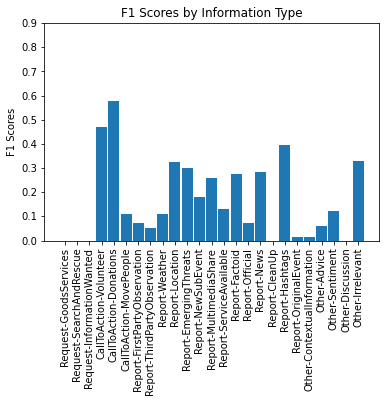

In [7]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Type Categorization
# Per Information Type F1 Graph
# --------------------------------------------------
# Per Category Classification Performance
# F1 scores for each information type, graphed
# Does not average across events (larger events have more impact)



N = len(informationTypes2Index)
ind = np.arange(N)

scoresPerCategoryF1 = []
categoryLabels = []
for categoryId in informationTypes2Index.keys():
    scoresPerCategoryF1.append(f1_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary'))
    categoryLabels.append(categoryId)
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, scoresPerCategoryF1, width)

plt.ylabel('F1 Scores')
plt.title('F1 Scores by Information Type')
plt.xticks(ind, categoryLabels, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [8]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Type Categorization
# Per Event Performance
# --------------------------------------------------
# Categorization performance for each event
# Precision, recall and F1 only consider the positive class
# Accuracy is an overall metric
# We report performance for all categories, high importance categories and low importance categories
# Macro average (categories have equal weight)

perEventFile.write("--------------------------------------------------"+"\n")
perEventFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
perEventFile.write("Per Event Performance"+"\n")
perEventFile.write("--------------------------------------------------"+"\n")

for eventId in eventIdentifiers:
    tavgPrecision = 0.0
    tavgRecall = 0.0
    tavgF1 = 0.0
    tavgAccuracy = 0.0
    
    tavgPrecisionHigh = 0.0
    tavgRecallHigh = 0.0
    tavgF1High = 0.0
    tavgAccuracyHigh = 0.0

    tavgPrecisionLow = 0.0
    tavgRecallLow = 0.0
    tavgF1Low = 0.0
    tavgAccuracyLow = 0.0

    for categoryId in informationTypes2Index.keys():
        
        categoryPrecision = precision_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        categoryRecall = recall_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        categoryF1 = f1_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        categoryAccuracy = accuracy_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId))
        
        tavgPrecision = tavgPrecision + categoryPrecision
        tavgRecall = tavgRecall + categoryRecall
        tavgF1 = tavgF1 + categoryF1
        tavgAccuracy = tavgAccuracy + categoryAccuracy
        
        if any(categoryId in s for s in highImportCategories):
            tavgPrecisionHigh = tavgPrecisionHigh + categoryPrecision
            tavgRecallHigh = tavgRecallHigh + categoryRecall
            tavgF1High = tavgF1High + categoryF1
            tavgAccuracyHigh = tavgAccuracyHigh + categoryAccuracy
        else:
            tavgPrecisionLow = tavgPrecisionLow + categoryPrecision
            tavgRecallLow = tavgRecallLow + categoryRecall
            tavgF1Low = tavgF1Low + categoryF1
            tavgAccuracyLow = tavgAccuracyLow + categoryAccuracy
        
    print(eventId)
    print("  Information Type Precision (positive class, multi-type, macro): "+str(tavgPrecision/len(informationTypes2Index)))
    print("  Information Type Recall (positive class, multi-type, macro): "+str(tavgRecall/len(informationTypes2Index)))
    print("  Information Type F1 (positive class, multi-type, macro): "+str(tavgF1/len(informationTypes2Index)))
    print("  Information Type Accuracy (overall, multi-type, macro): "+str(tavgAccuracy/len(informationTypes2Index)))
    print("  High Importance Information Type Precision (positive class, multi-type, macro): "+str(tavgPrecisionHigh/numHighInformationTypes))
    print("  High Importance Information Type Recall (positive class, multi-type, macro): "+str(tavgRecallHigh/numHighInformationTypes))
    print("  High Importance Information Type F1 (positive class, multi-type, macro): "+str(tavgF1High/numHighInformationTypes))
    print("  High Importance Information Type Accuracy (overall, multi-type, macro): "+str(tavgAccuracyHigh/numHighInformationTypes))
    print("  Low Importance Information Type Precision (positive class, multi-type, macro): "+str(tavgPrecisionLow/numLowInformationTypes))
    print("  Low Importance Information Type Recall (positive class, multi-type, macro): "+str(tavgRecallLow/numLowInformationTypes))
    print("  Low Importance Information Type F1 (positive class, multi-type, macro): "+str(tavgF1Low/numLowInformationTypes))
    print("  Low Importance Information Type Accuracy (overall, multi-type, macro): "+str(tavgAccuracyLow/numLowInformationTypes))
    print("")
    
    perEventFile.write(eventId+"\n")
    perEventFile.write("  Information Type Precision (positive class, multi-type, macro): "+str(tavgPrecision/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type Recall (positive class, multi-type, macro): "+str(tavgRecall/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type F1 (positive class, multi-type, macro): "+str(tavgF1/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type Accuracy (overall, multi-type, macro): "+str(tavgAccuracy/len(informationTypes2Index))+"\n")
    perEventFile.write("  High Importance Information Type Precision (positive class, multi-type, macro): "+str(tavgPrecisionHigh/numHighInformationTypes)+"\n")
    perEventFile.write("  High Importance Information Type Recall (positive class, multi-type, macro): "+str(tavgRecallHigh/numHighInformationTypes)+"\n")
    perEventFile.write("  High Importance Information Type F1 (positive class, multi-type, macro): "+str(tavgF1High/numHighInformationTypes)+"\n")
    perEventFile.write("  High Importance Information Type Accuracy (overall, multi-type, macro): "+str(tavgAccuracyHigh/numHighInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type Precision (positive class, multi-type, macro): "+str(tavgPrecisionLow/numLowInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type Recall (positive class, multi-type, macro): "+str(tavgRecallLow/numLowInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type F1 (positive class, multi-type, macro): "+str(tavgF1Low/numLowInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type Accuracy (overall, multi-type, macro): "+str(tavgAccuracyLow/numLowInformationTypes)+"\n")
    perEventFile.write("\n")
    
perEventFile.write("\n")

athensEarthquake2020
  Information Type Precision (positive class, multi-type, macro): 0.0
  Information Type Recall (positive class, multi-type, macro): 0.0
  Information Type F1 (positive class, multi-type, macro): 0.0
  Information Type Accuracy (overall, multi-type, macro): 0.9479069767441862
  High Importance Information Type Precision (positive class, multi-type, macro): 0.0
  High Importance Information Type Recall (positive class, multi-type, macro): 0.0
  High Importance Information Type F1 (positive class, multi-type, macro): 0.0
  High Importance Information Type Accuracy (overall, multi-type, macro): 0.9957716701902749
  Low Importance Information Type Precision (positive class, multi-type, macro): 0.0
  Low Importance Information Type Recall (positive class, multi-type, macro): 0.0
  Low Importance Information Type F1 (positive class, multi-type, macro): 0.0
  Low Importance Information Type Accuracy (overall, multi-type, macro): 0.9327918103927896

baltimoreFlashFlood2020

myanmarFloods2020
  Information Type Precision (positive class, multi-type, macro): 0.4558039816820916
  Information Type Recall (positive class, multi-type, macro): 0.2850458140483203
  Information Type F1 (positive class, multi-type, macro): 0.3449662060769592
  Information Type Accuracy (overall, multi-type, macro): 0.9628936170212765
  High Importance Information Type Precision (positive class, multi-type, macro): 0.2916666666666667
  High Importance Information Type Recall (positive class, multi-type, macro): 0.15282392026578073
  High Importance Information Type F1 (positive class, multi-type, macro): 0.2002840909090909
  High Importance Information Type Accuracy (overall, multi-type, macro): 0.9826241134751773
  Low Importance Information Type Precision (positive class, multi-type, macro): 0.5076368180027521
  Low Importance Information Type Recall (positive class, multi-type, macro): 0.3268000962954381
  Low Importance Information Type F1 (positive class, multi-type, macro): 0.

1

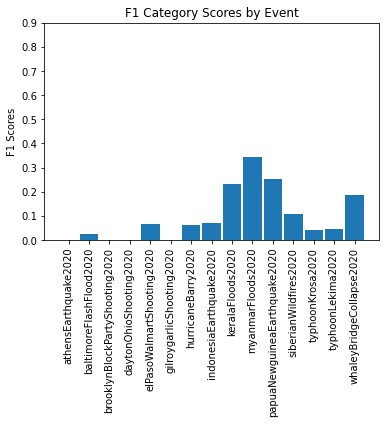

In [9]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Type Categorization
# Per Event F1 Graph
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# Macro average (categories have equal weight)

N = len(eventIdentifiers)
ind = np.arange(N)

scoresPerEventF1 = []
for eventId in eventIdentifiers:
    avgF1_ = 0.0
    
    for categoryId in informationTypes2Index.keys():
        avgF1_ = avgF1_ + f1_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        
    scoresPerEventF1.append(avgF1_/len(informationTypes2Index))
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, scoresPerEventF1, width)

plt.ylabel('F1 Scores')
plt.title('F1 Category Scores by Event')
plt.xticks(ind, eventIdentifiers, rotation='vertical')
plt.yticks(np
           .arange(0, 1, 0.1))

plt.show()

In [10]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Priority Level
# Overall Performance
# --------------------------------------------------
# How divergent is the system from the human priority labels?
# F1 performance over information types, higher is better
# Macro average (categories have equal weight)

from sklearn.metrics import mean_squared_error

priorityAvgf1 = 0.0;
priorityAvgf1High = 0.0;
priorityAvgf1Low = 0.0;
for categoryId in informationTypes2Index.keys():
    groundTruthPriorities = category2GroundTruthPriority[categoryId]
    predictedPriorities = category2PredictedPriority[categoryId]

    f1 = f1_score(groundTruthPriorities, predictedPriorities, average='macro')
    priorityAvgf1 = priorityAvgf1 + f1;
    
    if any(categoryId in s for s in highImportCategories):
        priorityAvgf1High = priorityAvgf1High + f1
    else:
        priorityAvgf1Low = priorityAvgf1Low + f1
    
    
    
print("Priority Label Prediction (F1, macro): "+str(priorityAvgf1/len(informationTypes2Index)))
print("Priority Label Prediction High Importance (F1, macro): "+str(priorityAvgf1High/numHighInformationTypes))
print("Priority Label Prediction Low Importance (F1, macro): "+str(priorityAvgf1Low/numLowInformationTypes))
    
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Priority Level"+"\n")
resultsFile.write("Overall Performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Priority Label Prediction (F1, macro): "+str(priorityAvgf1/len(informationTypes2Index))+"\n")
resultsFile.write("> Priority Label Prediction High Importance (F1, macro): "+str(priorityAvgf1High/numHighInformationTypes)+"\n")
resultsFile.write("> Priority Label Prediction Low Importance (F1, macro): "+str(priorityAvgf1Low/numLowInformationTypes)+"\n")
resultsFile.write("\n")

'''
Priority Label Prediction (F1, macro): 0.17789293558612237
Priority Label Prediction High Importance (F1, macro): 0.06457810783990874
Priority Label Prediction Low Importance (F1, macro): 0.21367656540071608
// Subset of selected.json
Priority Label Prediction (F1, macro): 0.18414638169354325
Priority Label Prediction High Importance (F1, macro): 0.07393693861085165
Priority Label Prediction Low Importance (F1, macro): 0.2189493637196564
// All selected.json loaded
Priority Label Prediction (F1, macro): 0.329702967947908
Priority Label Prediction High Importance (F1, macro): 0.16318618536713062
Priority Label Prediction Low Importance (F1, macro): 0.3822872150786798

// Counting categories properly
Priority Label Prediction (F1, macro): 0.21481839425257468
Priority Label Prediction High Importance (F1, macro): 0.14300090499390425
Priority Label Prediction Low Importance (F1, macro): 0.23749760138689163

// Tidying code passing / dataframes
Priority Label Prediction (F1, macro): 0.2692907991421786
Priority Label Prediction High Importance (F1, macro): 0.15697230759182423
Priority Label Prediction Low Importance (F1, macro): 0.30475979647386947
'''

Priority Label Prediction (F1, macro): 0.17553995881023055
Priority Label Prediction High Importance (F1, macro): 0.09219263539561305
Priority Label Prediction Low Importance (F1, macro): 0.20186016620432032


'\nPriority Label Prediction (F1, macro): 0.17789293558612237\nPriority Label Prediction High Importance (F1, macro): 0.06457810783990874\nPriority Label Prediction Low Importance (F1, macro): 0.21367656540071608\n// Subset of selected.json\nPriority Label Prediction (F1, macro): 0.18414638169354325\nPriority Label Prediction High Importance (F1, macro): 0.07393693861085165\nPriority Label Prediction Low Importance (F1, macro): 0.2189493637196564\n// All selected.json loaded\nPriority Label Prediction (F1, macro): 0.329702967947908\nPriority Label Prediction High Importance (F1, macro): 0.16318618536713062\nPriority Label Prediction Low Importance (F1, macro): 0.3822872150786798\n\n// Counting categories properly\nPriority Label Prediction (F1, macro): 0.21481839425257468\nPriority Label Prediction High Importance (F1, macro): 0.14300090499390425\nPriority Label Prediction Low Importance (F1, macro): 0.23749760138689163\n\n// Tidying code passing / dataframes\nPriority Label Prediction

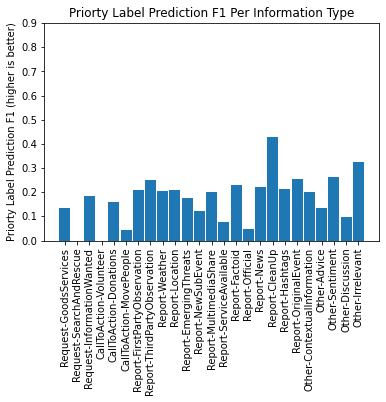

In [11]:
# --------------------------------------------------
# TREC-IS 2020-A
# Task 1
# Information Priority Level
# Per Information Type Performance
# --------------------------------------------------
# F1 per information type (macro averaged), higher is better
# Macro average (categories have equal weight)

N = len(informationTypes2Index)
ind = np.arange(N)

priorityCatF1Values = []
categoryLabels = []
for categoryId in informationTypes2Index.keys():
    groundTruthPriorities = category2GroundTruthPriority[categoryId]
    predictedPriorities = category2PredictedPriority[categoryId]
    priorityCatF1 = f1_score(groundTruthPriorities, predictedPriorities, average='macro')
    categoryLabels.append(categoryId)
    priorityCatF1Values.append(priorityCatF1);
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, priorityCatF1Values, width)

plt.ylabel('Priorty Label Prediction F1 (higher is better)')
plt.title('Priorty Label Prediction F1 Per Information Type')
plt.xticks(ind, categoryLabels, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [12]:
# Print the evaluation table row in latex
print("Run & NDCG & AW-H & AW-A & CF1-H & CF1-A & CAcc & PErr-H & PErr-A \\\\")

resultLine = (str.format('{0:.4f}', system_ndcg_micro)+
     " & "+
     str.format('{0:.4f}', totalHighImportWorth)+
     " & "+
     str.format('{0:.4f}', AccumulatedAlertWorth)+
     " & "+
     str.format('{0:.4f}',avgF1High/numHighInformationTypes)+
     " & "+
     str.format('{0:.4f}',avgF1/numInformationTypes)+
     " & "+
     str.format('{0:.4f}',avgAccuracy/numInformationTypes)+
     " & "+
     str.format('{0:.4f}',priorityAvgf1High/numHighInformationTypes)+
     " & "+
     str.format('{0:.4f}',priorityAvgf1/len(informationTypes2Index))+
     " \\\\")

print(runName+" & "+resultLine)

resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("LATEX"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write(runName+" & "+resultLine)

Run & NDCG & AW-H & AW-A & CF1-H & CF1-A & CAcc & PErr-H & PErr-A \\
marksrun2 & 0.4280 & -0.1686 & -0.0859 & 0.1199 & 0.1663 & 0.9216 & 0.0922 & 0.1755 \\


86

In [13]:
# Done
resultsFile.close() 
perTopicFile.close()
perEventFile.close()

In [14]:
'''
Run & NDCG & AW-H & AW-A & CF1-H & CF1-A & CAcc & PErr-H & PErr-A \\
marksrun & 0.3708 & 0.0000 & 0.0000 & 0.0000 & 0.0000 ›& 0.9287 & 0.0646 & 0.1779 \\
marksrun & 0.3695 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.9287 & 0.0646 & 0.1779 \\
marksrun & 0.3705 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.9285 & 0.0640 & 0.1505 \\


marksrun2 & 0.5440 & -0.1474 & -0.0739 & 0.1090 & 0.1872 & 0.9201 & 0.1569 & 0.2731 \\ priority_y -> x
marksrun2 & 0.5453 & -0.1459 & -0.0731 & 0.1037 & 0.1884 & 0.9200 & 0.1557 & 0.2740 \\ work on label map
marksrun2 & 0.5418 & -0.1505 & -0.0754 & 0.1151 & 0.1935 & 0.9203 & 0.1570 & 0.2693 \\ label/eventID tidy
marksrun2 & 0.5538 & -0.1505 & -0.0754 & 0.1063 & 0.1954 & 0.9213 & 0.1565 & 0.2715 \\ eventID passing properly
marksrun2 & 0.5825 & -0.1459 & -0.0731 & 0.1284 & 0.2172 & 0.9259 & 0.1549 & 0.2770 \\ labels passing properly
marksrun2 & 0.5527 & -0.2765 & -0.1382 & 0.0279 & 0.0645 & 0.9122 & 0.1125 & 0.2366 \\ tidying input labels df
marksrun2 & 0.5892 & -0.1612 & -0.0808 & 0.1452 & 0.2225 & 0.9246 & 0.1508 & 0.3074 \\
marksrun2 & 0.4947 & -0.2381 & -0.1207 & 0.1892 & 0.2318 & 0.9244 & 0.1679 & 0.2900 \\ BERT
marksrun2 & 0.4882 & -0.1647 & -0.0841 & 0.1890 & 0.2446 & 0.9258 & 0.1470 & 0.2351 \\






'''

'\nRun & NDCG & AW-H & AW-A & CF1-H & CF1-A & CAcc & PErr-H & PErr-A \\\nmarksrun & 0.3708 & 0.0000 & 0.0000 & 0.0000 & 0.0000 ›& 0.9287 & 0.0646 & 0.1779 \\\nmarksrun & 0.3695 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.9287 & 0.0646 & 0.1779 \\\nmarksrun & 0.3705 & 0.0000 & 0.0000 & 0.0000 & 0.0000 & 0.9285 & 0.0640 & 0.1505 \\\n\n\nmarksrun2 & 0.5440 & -0.1474 & -0.0739 & 0.1090 & 0.1872 & 0.9201 & 0.1569 & 0.2731 \\ priority_y -> x\nmarksrun2 & 0.5453 & -0.1459 & -0.0731 & 0.1037 & 0.1884 & 0.9200 & 0.1557 & 0.2740 \\ work on label map\nmarksrun2 & 0.5418 & -0.1505 & -0.0754 & 0.1151 & 0.1935 & 0.9203 & 0.1570 & 0.2693 \\ label/eventID tidy\nmarksrun2 & 0.5538 & -0.1505 & -0.0754 & 0.1063 & 0.1954 & 0.9213 & 0.1565 & 0.2715 \\ eventID passing properly\nmarksrun2 & 0.5825 & -0.1459 & -0.0731 & 0.1284 & 0.2172 & 0.9259 & 0.1549 & 0.2770 \\ labels passing properly\nmarksrun2 & 0.5527 & -0.2765 & -0.1382 & 0.0279 & 0.0645 & 0.9122 & 0.1125 & 0.2366 \\ tidying input labels df\nmarksrun2 & 0

In [15]:
# Compare Algorithms
import matplotlib.pyplot as plt
from matplotlib import rcParams
# Set the figure size
rcParams['figure.figsize'] = 20,10
data = pd.read_csv('../../../2-status_report/results2.txt', sep="&")



data



,marksrun,0.3708,0.0000,0.0000 .1,0.0000 .2,0.0000 ›,0.9287,0.0646,0.1779,
0,marksrun,0.3695,0.0000,0.0000,0.0000,0.0000,0.9287,0.0646,0.1779,
1,marksrun,0.3705,0.0000,0.0000,0.0000,0.0000,0.9285,0.0640,0.1505,
2,marksrun2,0.3723,0.0000,0.0000,0.0000,0.0000,0.9285,0.0640,0.1505,
3,marksrun2,0.3710,0.0000,0.0000,0.0000,0.0000,0.9285,0.0640,0.1505,
4,marksrun2,0.3690,0.0000,0.0000,0.0000,0.0000,0.9285,0.0546,0.1686,Multiple labels now mapping
5,marksrun2,0.3690,0.0000,0.0000,0.0000,0.0000,0.9287,0.0646,0.1779,
6,marksrun2,0.3746,0.0000,0.0000,0.0000,0.0000,0.9287,0.0739,0.1841,Fixed label capitalisation
7,marksrun2,0.3741,0.0000,0.0000,0.0220,0.0323,0.9292,0.0733,0.1636,Adding events in
8,marksrun2,0.3973,-0.0020,-0.0010,0.0017,0.0253,0.9307,0.0776,0.1713,
9,marksrun2,0.3993,-0.0013,-0.0007,0.0950,0.0980,0.9319,0.0855,0.2017,


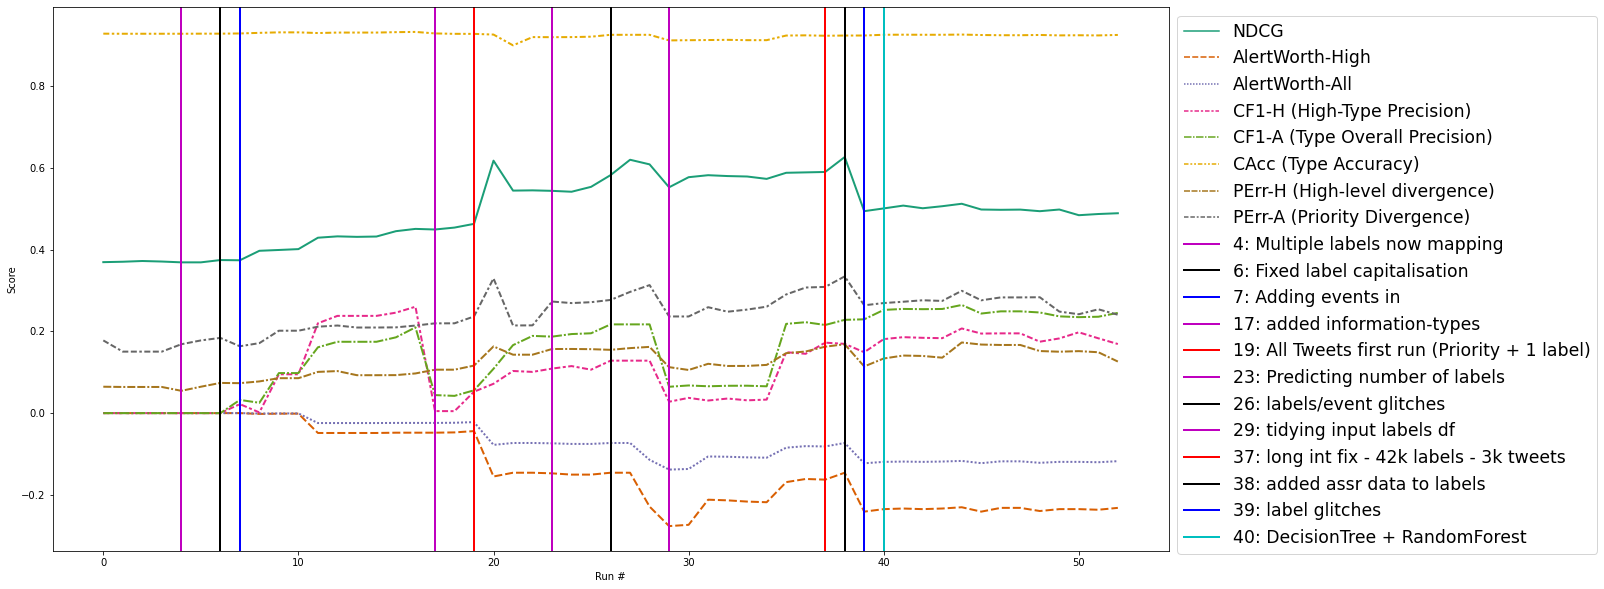

In [16]:
import seaborn as sns


data.columns = ["run", "NDCG", "AlertWorth-High" , "AlertWorth-All" , "CF1-H (High-Type Precision)" , "CF1-A (Type Overall Precision)" , "CAcc (Type Accuracy)" , "PErr-H (High-level divergence)", "PErr-A (Priority Divergence)", "Notes"]


ax = sns.lineplot(data=data, palette="Dark2", linewidth=2, linestyle='--')
ax.set(xlabel="Run #", ylabel = "Score")

# Increase the font-size for the legend
#fig.suptitle('Marks runs')


# x coordinates for the lines
xcoords = [0.1, 0.3, 0.5]
# colors for the lines
colors = ['r','k','b','c','m','r','k','b','c','m','y','r','m','r','k','b','c','m','y','r','k','b','c','m','y','r','k','b','c','m','y','r','k','b','c','m','y','r','k','b','c','m','y']


i = -1    
for row, c, in zip(data.iterrows(),colors):
    #print(row.index)
    i = i+1
    if(len(row[1].Notes) != 1):
        ax.axvline(x=i, label=str(i) + ":" + row[1].Notes , c=colors[i], linestyle='-', linewidth=2)



plt.legend(bbox_to_anchor=(1.0, 1), fontsize='xx-large', title_fontsize='30', loc='upper left')

plt.show()


#plt.savefig('../../../0-data/screenshots/results.png',dpi=300)




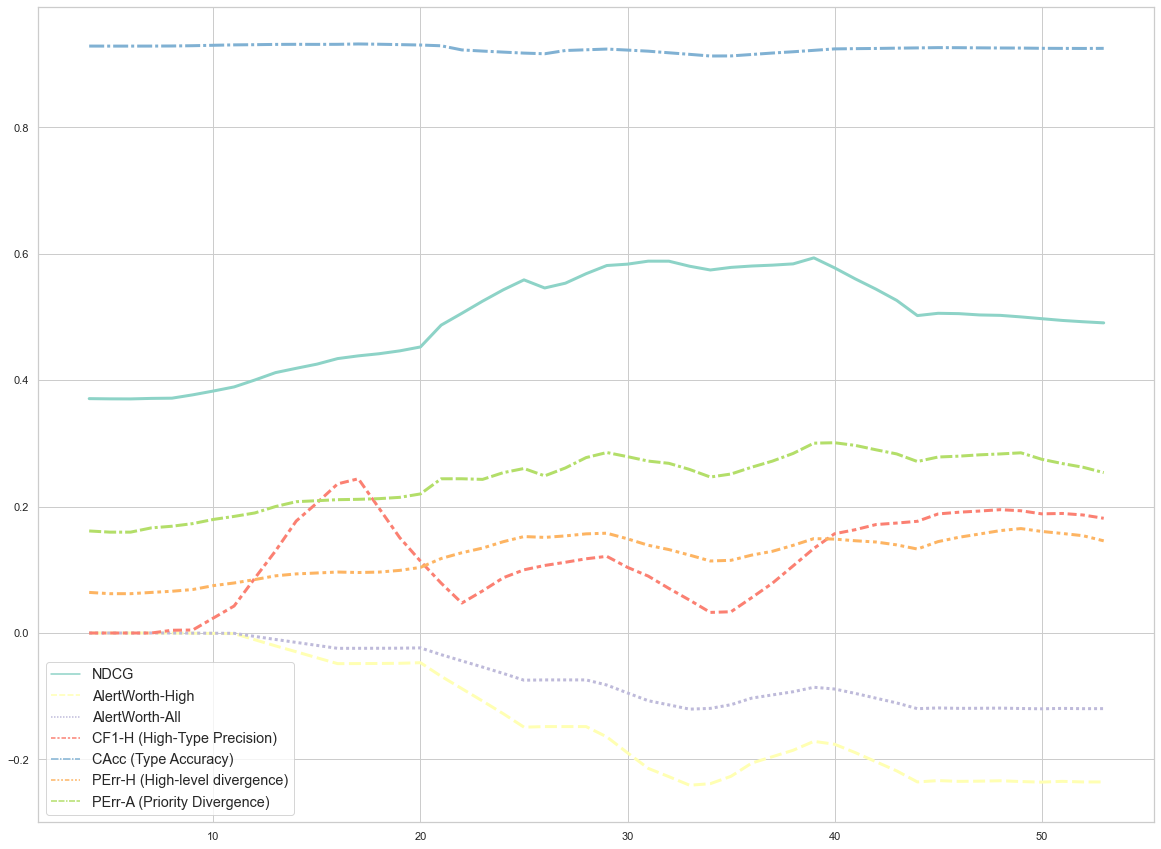

<Figure size 1440x1080 with 0 Axes>

In [17]:
# Results

# Set the figure size
rcParams['figure.figsize'] = 20,15

# Seaborn theme 
sns.set_theme(style="whitegrid")

# Read the results.txt file in
data = pd.read_csv('../../../2-status_report/results2.txt', sep="&", header=None)

# Set the column names
data.columns = ["run", "NDCG", "AlertWorth-High" , "AlertWorth-All" , "CF1-H (High-Type Precision)" , "CF1-A (Type Overall Precision)" , "CAcc (Type Accuracy)" , "PErr-H (High-level divergence)", "PErr-A (Priority Divergence)", "Notes"]


# Take a rolling mean
data = data.rolling(5).mean()

sns.lineplot(data=data, palette="Set3", linewidth=3)

# Increase the font-size for the legend
#fig.suptitle('Marks runs')
plt.legend(fontsize='large', title_fontsize='10')

plt.show()

plt.savefig('../../../0-data/screenshots/benchmark_models_performance.png',dpi=300)


